In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('kenya_tripadvisor_data_1.csv')
df1.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Giraffe Centre,Nature/Parks,5,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,June 2017
1,Giraffe Centre,Nature/Parks,4,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,December 2016
2,Giraffe Centre,Nature/Parks,3,Close to the giraffes,You get to come very close to the giraffes. Yo...,June 2017
3,Giraffe Centre,Nature/Parks,5,Giraffe kiss!,If you like giraffes you'll love this place. E...,June 2017
4,Giraffe Centre,Nature/Parks,5,A wonderful moment in time.,We always visit this attraction each and every...,June 2017


In [3]:
df2 = df1.copy()
df2.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Giraffe Centre,Nature/Parks,5,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,June 2017
1,Giraffe Centre,Nature/Parks,4,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,December 2016
2,Giraffe Centre,Nature/Parks,3,Close to the giraffes,You get to come very close to the giraffes. Yo...,June 2017
3,Giraffe Centre,Nature/Parks,5,Giraffe kiss!,If you like giraffes you'll love this place. E...,June 2017
4,Giraffe Centre,Nature/Parks,5,A wonderful moment in time.,We always visit this attraction each and every...,June 2017


In [4]:
from nltk import tokenize

df2.drop('Rating', axis = 1, inplace = True)
df2.drop('Date', axis = 1, inplace = True)
df2['Review Head'] = df2['Review Head'].apply(lambda x: re.sub('\s+', ' ', x))
df2['Review Body'] = df2['Review Body'].apply(lambda x: re.sub('\s+', ' ', x))
df2['RB_Sentence1'] = df2['Review Body'].apply(lambda x: tokenize.sent_tokenize(x)[0])
df2['RH_Split'] = df2['Review Head'].apply(lambda x: x.split(' '))
df2['RB_Split'] = df2['Review Body'].apply(lambda x: x.split(' '))
df2['RB_Sentence1_Split'] = df2['RB_Sentence1'].apply(lambda x: x.split(' '))
df2['TextBlob Polarity Head'] = df2['Review Head'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity Body'] = df2['Review Body'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity RBS1'] = df2['RB_Sentence1'].map(lambda text: TextBlob(text).sentiment.polarity)

In [5]:
df2.head()

,Destination Name,Destination Type,Review Head,Review Body,RB_Sentence1,RH_Split,RB_Split,RB_Sentence1_Split,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity RBS1
0,Giraffe Centre,Nature/Parks,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,If you find yourself with a day in Nairobi bef...,"[Giraffes, and, Baby, Elephants!]","[If, you, find, yourself, with, a, day, in, Na...","[If, you, find, yourself, with, a, day, in, Na...",0.0,0.160000,0.16
1,Giraffe Centre,Nature/Parks,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,A fun place to visit - you not only get to fee...,"[Places, to, visit, in, Karen, -, Giraffe, Cen...","[A, fun, place, to, visit, -, you, not, only, ...","[A, fun, place, to, visit, -, you, not, only, ...",0.0,0.450000,0.15
2,Giraffe Centre,Nature/Parks,Close to the giraffes,You get to come very close to the giraffes. Yo...,You get to come very close to the giraffes.,"[Close, to, the, giraffes]","[You, get, to, come, very, close, to, the, gir...","[You, get, to, come, very, close, to, the, gir...",0.0,0.100000,0.20
3,Giraffe Centre,Nature/Parks,Giraffe kiss!,If you like giraffes you'll love this place. E...,If you like giraffes you'll love this place.,"[Giraffe, kiss!]","[If, you, like, giraffes, you'll, love, this, ...","[If, you, like, giraffes, you'll, love, this, ...",0.0,0.200000,0.50
4,Giraffe Centre,Nature/Parks,A wonderful moment in time.,We always visit this attraction each and every...,We always visit this attraction each and every...,"[A, wonderful, moment, in, time.]","[We, always, visit, this, attraction, each, an...","[We, always, visit, this, attraction, each, an...",1.0,0.214286,0.00


In [6]:
df2['Destination Type'].value_counts()

Nature/Parks    21143
Museums          4685
Landmarks        3307
Name: Destination Type, dtype: int64

### Topic Modelling

In [7]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df2['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 16736
Neutral : 112476
Negative : 618


In [8]:
from nltk.corpus import stopwords

# main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
#                        'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
#                        'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
#                        'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
#                        '\n', '‘s']

main_stop_words = ['kenya', 'kenyan', 'africa', 'african', 'church', 'churches', 'park', 'parks', 'museum', 'museums',
                   'lamu', 'valley', 'mountain', 'mountains', 'national', 'nairobi', 'amboseli'  
                   'cathedral', 'cathedrals', 'place', 'visit', 'site', 'town',  
                   '\n', '‘s']

positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  1493


In [9]:
# Convert to list
data = df2[df2['Destination Type'] == 'Museums'][df2['TextBlob Polarity Head'] > 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['rich with history']


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['rich', 'with', 'history']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['rich', 'with', 'history']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['history']]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('history', 1)]]

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.167*"see" + 0.104*"little" + 0.072*"informative" + 0.049*"movie" + '
  '0.040*"do" + 0.032*"find" + 0.031*"lot" + 0.031*"original" + '
  '0.030*"regional" + 0.028*"well"'),
 (1,
  '0.107*"spend" + 0.100*"hour" + 0.073*"afternoon" + 0.073*"educational" + '
  '0.066*"day" + 0.064*"way" + 0.053*"quick" + 0.023*"half" + 0.019*"full" + '
  '0.017*"quite"'),
 (2,
  '0.129*"culture" + 0.100*"cultural" + 0.051*"dance" + 0.049*"show" + '
  '0.046*"family" + 0.046*"natural" + 0.046*"feel" + 0.036*"go" + '
  '0.019*"music" + 0.019*"traditional"'),
 (3,
  '0.276*"worth" + 0.095*"time" + 0.051*"trip" + 0.036*"small" + 0.034*"visit" '
  '+ 0.032*"unexpectedly" + 0.032*"seriously" + 0.026*"first" + 0.024*"lunch" '
  '+ 0.023*"stop"'),
 (4,
  '0.099*"display" + 0.092*"tour" + 0.073*"bird" + 0.056*"local" + '
  '0.055*"date" + 0.048*"skull" + 0.037*"view" + 0.032*"morning" + '
  '0.030*"early" + 0.021*"human"'),
 (5,
  '0.121*"really" + 0.100*"old" + 0.080*"much" + 0.069*"learn" + 0.053*"mix"

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.928680158661463

Coherence Score:  0.6412428859517357


In [19]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('history', 0.2135593220338983),
   ('fan', 0.05423728813559322),
   ('kid', 0.04067796610169491),
   ('cool', 0.03389830508474576),
   ('display', 0.03389830508474576),
   ('worthwhile', 0.03389830508474576),
   ('snake', 0.02711864406779661),
   ('tourist', 0.023728813559322035),
   ('absolutely', 0.023728813559322035),
   ('thing', 0.020338983050847456)]),
 (1,
  [('tour', 0.18032786885245902),
   ('informative', 0.14754098360655737),
   ('exhibit', 0.07540983606557378),
   ('piece', 0.06229508196721312),
   ('half', 0.029508196721311476),
   ('alive', 0.02622950819672131),
   ('animal', 0.02622950819672131),
   ('big', 0.022950819672131147),
   ('maintain', 0.022950819672131147),
   ('explore', 0.019672131147540985)]),
 (2,
  [('historical', 0.11538461538461539),
   ('spend', 0.10576923076923077),
   ('hour', 0.09615384615384616),
   ('afternoon', 0.0673076923076923),
   ('dance', 0.0641025641025641),
   ('show', 0.060897435897435896),
   ('experience', 0.05448717948717949)

2
3
4
5
6
7
8
9
10


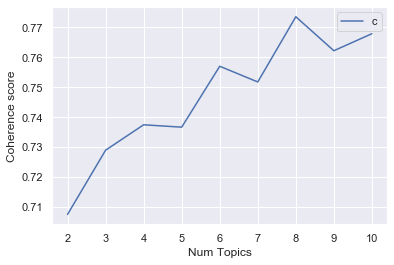

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7075
Num Topics = 3  has Coherence Value of 0.729
Num Topics = 4  has Coherence Value of 0.7375
Num Topics = 5  has Coherence Value of 0.7367
Num Topics = 6  has Coherence Value of 0.757
Num Topics = 7  has Coherence Value of 0.7518
Num Topics = 8  has Coherence Value of 0.7735
Num Topics = 9  has Coherence Value of 0.7622
Num Topics = 10  has Coherence Value of 0.7679


In [24]:
optimal_model = model_list[6] # Number of Topics = 8

# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.105*"time" + 0.083*"spend" + 0.075*"experience" + 0.058*"exhibit" + '
  '0.030*"kid" + 0.025*"back" + 0.025*"location" + 0.022*"family" + '
  '0.020*"past" + 0.018*"maintain"'),
 (1,
  '0.098*"culture" + 0.090*"day" + 0.085*"educational" + 0.049*"trip" + '
  '0.046*"real" + 0.041*"fan" + 0.028*"full" + 0.026*"worthwhile" + '
  '0.023*"read" + 0.023*"half"'),
 (2,
  '0.292*"history" + 0.072*"small" + 0.062*"movie" + 0.044*"early" + '
  '0.041*"bit" + 0.028*"surprisingly" + 0.026*"woman" + 0.023*"set" + '
  '0.021*"alive" + 0.018*"cheap"'),
 (3,
  '0.320*"worth" + 0.052*"afternoon" + 0.052*"piece" + 0.048*"view" + '
  '0.035*"home" + 0.028*"spot" + 0.025*"snake" + 0.022*"stay" + '
  '0.020*"property" + 0.018*"city"'),
 (4,
  '0.476*"history" + 0.026*"bird" + 0.026*"local" + 0.023*"make" + 0.023*"lot" '
  '+ 0.021*"human" + 0.021*"insight" + 0.021*"tribe" + 0.015*"information" + '
  '0.015*"unexpected"'),
 (5,
  '0.138*"tour" + 0.110*"experience" + 0.090*"historical" + 0.058*"di

In [25]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.061122 -0.191677       1        1  12.582830
0      0.126160  0.257806       2        1  12.520800
2     -0.364017  0.048497       3        1  12.495411
3      0.138205  0.135587       4        1  12.494975
1      0.085888 -0.295248       5        1  12.494583
4     -0.351904  0.019962       6        1  12.476942
5      0.176626  0.149495       7        1  12.467348
6      0.127920 -0.124422       8        1  12.467111, topic_info=    Category        Freq             Term       Total  loglift  logprob
0    Default  359.000000          history  359.000000  30.0000  30.0000
48   Default  150.000000            worth  150.000000  29.0000  29.0000
31   Default   64.000000             tour   64.000000  28.0000  28.0000
83   Default   56.000000      informative   56.000000  27.0000  27.0000
32   Default   93.000000       experience   93.000000  26.0000  26.0000
44   Default   50.000000       collection   50.000000  25.0000  25.0000
93   Default   49.000000         cultural   49.000000  24.0000  24.0000
107  Default   56.000000             time   56.000000  23.0000  23.0000
122  Default   42.000000              day   42.000000  22.0000  22.0000
5    Default   43.000000       historical   43.000000  21.0000  21.0000
39   Default   54.000000          culture   54.000000  20.0000  20.0000
42   Default   39.000000      educational   39.000000  19.0000  19.0000
64   Default   38.000000            spend   38.000000  18.0000  18.0000
59   Default   36.000000            guide   36.000000  17.0000  17.0000
45   Default   33.000000              art   33.000000  16.0000  16.0000
86   Default   33.000000            small   33.000000  15.0000  15.0000
63   Default   37.000000             hour   37.000000  14.0000  14.0000
172  Default   28.000000            movie   28.000000  13.0000  13.0000
65   Default   40.000000            learn   40.000000  12.0000  12.0000
100  Default   26.000000          display   26.000000  11.0000  11.0000
137  Default   27.000000          exhibit   27.000000  10.0000  10.0000
145  Default   24.000000        afternoon   24.000000   9.0000   9.0000
208  Default   23.000000             show   23.000000   8.0000   8.0000
217  Default   25.000000            piece   25.000000   7.0000   7.0000
54   Default   23.000000         historic   23.000000   6.0000   6.0000
43   Default   22.000000             view   22.000000   5.0000   5.0000
114  Default   24.000000             trip   24.000000   4.0000   4.0000
270  Default   21.000000             real   21.000000   3.0000   3.0000
206  Default   23.000000            dance   23.000000   2.0000   2.0000
215  Default   20.000000           ground   20.000000   1.0000   1.0000
..       ...         ...              ...         ...      ...      ...
89    Topic8   11.295604             part   11.295604   2.0821  -3.7244
148   Topic8    8.785470             live    8.785470   2.0821  -3.9757
167   Topic8    5.020268        overprice    5.020268   2.0821  -4.5353
532   Topic8    3.765201            check    3.765201   2.0821  -4.8230
621   Topic8    3.765201             rest    3.765201   2.0821  -4.8230
537   Topic8    3.765201             east    3.765201   2.0821  -4.8230
742   Topic8    1.255067            final    1.255067   2.0821  -5.9216
701   Topic8    1.255067        intresste    1.255067   2.0821  -5.9216
702   Topic8    1.255067             farm    1.255067   2.0821  -5.9216
87    Topic8    1.255067         deserted    1.255067   2.0821  -5.9216
708   Topic8    1.255067         footstep    1.255067   2.0821  -5.9216
63    Topic8   35.141879             hour   37.492660   2.0173  -2.5894
491   Topic8    1.255067          awkward    1.255067   2.0821  -5.9216
104   Topic8    1.255067  anthropological    1.255067   2.0821  -5.9216
760   Topic8    1.255067           redone    1.255067   2.0821  -5.9216
353   Topic8   18.826007     intr

In [26]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.1356,"history, bird, local, make, lot, human, insigh...",rich with history
1,1,0.0,0.1250,"time, spend, experience, exhibit, kid, back, l...",An old portugese fort
2,2,6.0,0.1334,"informative, hour, art, show, introduction, ov...","Most probably, most important place to see in ..."
3,3,4.0,0.1378,"history, bird, local, make, lot, human, insigh...",Amazing and rich history
4,4,5.0,0.1422,"tour, experience, historical, display, histori...",Great historical monument
5,5,2.0,0.1356,"history, small, movie, early, bit, surprisingl...",Beautiful place with very rich history
6,6,3.0,0.1422,"worth, afternoon, piece, view, home, spot, sna...",Perfect Place to Stay at Wilson Airport
7,7,0.0,0.1394,"time, spend, experience, exhibit, kid, back, l...","A friendly, no frills, efficient facility, clo..."
8,8,6.0,0.1544,"informative, hour, art, show, introduction, ov...",Absolutely unique!
9,9,2.0,0.1394,"history, small, movie, early, bit, surprisingl...","Old Aero Club, Nairobi"


In [27]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    1215
1.0     245
3.0     240
5.0     222
4.0     212
2.0     206
7.0     198
6.0     189
Name: Dominant_Topic, dtype: int64

In [28]:
df_dominant_topic.to_csv('kenya_452.csv', index = False)

In [40]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 2

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Topicless/Unidentifiable - 1215
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # History Appreciation - 245
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # History Appreciation - 206
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Visual (Aesthetic, Curation, etc.) - 240
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # History Appreciation - 212
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Tour Appreciation - 222
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # History Appreciation - 189
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Visual (Aesthetic, Curation, etc.) - 198

In [41]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 1

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # General Appreciation - 876
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Commending Tour Organization - 210
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Visual (Aesthetic, Scenery, etc.) - 188
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # History Appreciation - 177
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Food Appreciation - 161 
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # General Appreciation - 126
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Food Appreciation - 159

In [42]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1745,"time, spend, experience, exhibit, kid, back, l...",Of 4 Pythons and a journey back to my beautifu...
1,1.0,0.1713,"culture, day, educational, trip, real, fan, fu...",Wonderful half day trip for kids in Nairobi
2,2.0,0.1692,"history, small, movie, early, bit, surprisingl...","Small museum, great hands-on train yard."
3,3.0,0.1661,"worth, afternoon, piece, view, home, spot, sna...",Great view...low doors!
4,4.0,0.1671,"history, bird, local, make, lot, human, insigh...",Interesting exhibits about early human evoluti...
5,5.0,0.1672,"tour, experience, historical, display, histori...",Varied displays with just the right amount of ...
6,6.0,0.1742,"informative, hour, art, show, introduction, ov...",A great destination to get an overview of life...
7,7.0,0.1969,"collection, cultural, guide, learn, dance, gro...",The Finest Collection - The museum is still of...


In [43]:
sent_topics_sorteddf_mallet['Text'].values

array(['Of 4 Pythons and a journey back to my beautiful past....',
       'Wonderful half day trip for kids in Nairobi',
       'Small museum, great hands-on train yard.',
       'Great view...low doors!',
       'Interesting exhibits about early human evolution, and the history, flora, fauna and ethnology of Kenya.',
       'Varied displays with just the right amount of text',
       'A great destination to get an overview of life in Africa in the early part of the 1900s',
       'The Finest Collection - The museum is still offering the best n terms of finest collections.'],
      dtype=object)

In [44]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics